# 深度学习：时间序列分析

为了便于下面的程序执行，我们先将需要的软件库提前载入当前系统。这些常用的软件库包括pandas，numpy，matplotlib以及statsmodels，当然还有keras。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import keras
import keras.models as kModels
import keras.layers as kLayers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.signal import periodogram
# warnings package is to eliminate annoying warning message from KPSS test
import warnings

from statsmodels.tsa.stattools import acf
from scipy import signal
#if you don't have peakutils package, install it by: pip install peakutils
try:
    import peakutils as peak
except ImportError:
    !pip install peakutils
    import peakutils as peak

plt.rcParams['figure.figsize']=(20, 10)
font = {'size'   : 20}
plt.rc('font', **font)

c:\Anaconda3\envs\cntkkeraspy35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using CNTK backend


In [2]:
np.random.seed(897871)
print(sm.version.full_version)

0.8.0


生成白噪声和随机行走序列

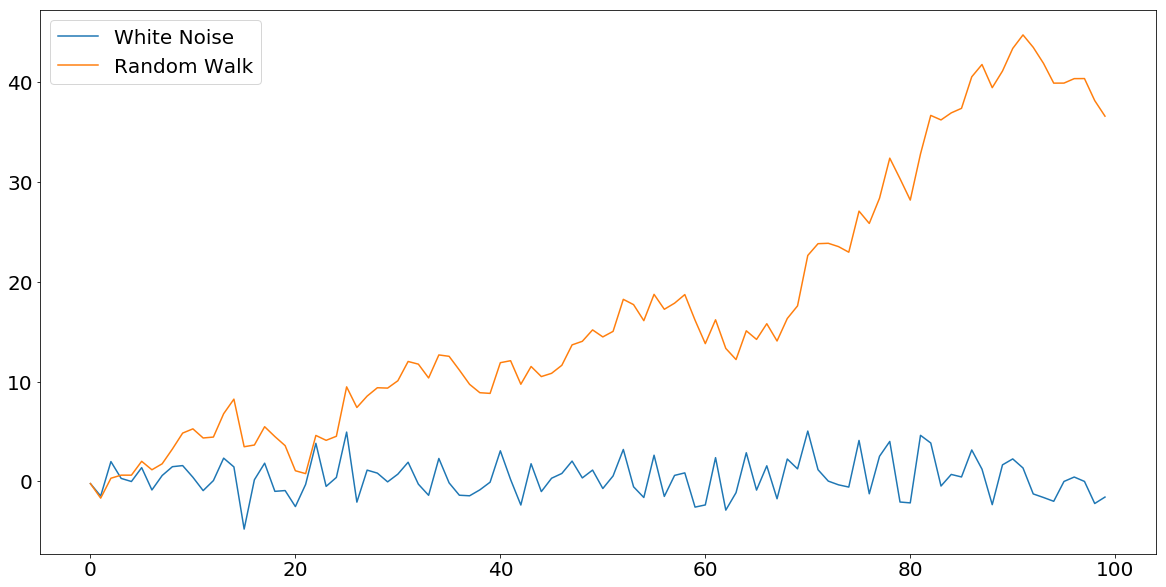

前20个数据点的均值为3.1296, 标准差为2.4466

后20个数据点的均值为38.9727, 标准差为3.7553


In [8]:
np.random.seed(1291)
z = np.random.normal(0.1, 2, 100)
y = np.cumsum(z)

fig, ax1 = plt.subplots()
plt.plot(z, label="White Noise")
plt.plot(y, label="Random Walk")
plt.legend()
plt.savefig('.././data/timeseries/WhiteNoise.png')

plt.show()

mean1 = np.round(np.mean(y[:20]), 4); mean2=np.round(np.mean(y[-20:]), 4)
std1 = np.round(np.std(y[:20]), 4); std2=np.round(np.std(y[-20:]), 4)


print("前20个数据点的均值为%.4f, 标准差为%.4f" %(mean1, std1))
print("")
print("后20个数据点的均值为%.4f, 标准差为%.4f" %(mean2, std2))

plt.close()
plt.show()

## 示例数据

我们的时间序列数据来自于 DataMarket 的时间序列数据库： https://datamarket.com/data/list/?q=provider:tsdl 。 这个库由澳大利亚莫纳什大学的统计学教授 Rob Hyndman 创建，收集了数十个公开的时间序列数据集。。Rob Hyndman教授也是R统计语言里面forecast软件包的开发者。本章我们采用其中两个数据作为实例。为了方便读者，都已经存入本地文件夹

第一个数据是在汉口测量的长江每月流量数据作为实例，该数据记录了从1865年一月到1978年十二月间在汉口记录的长江每月流量，总计1368个数据点，计量单位未知，不过不妨碍我们的分析过程和结果。我们将该数据下载后存入本地磁盘，路径为：..\.\data\TimeSeries\， 文件名为monthly-flows-chang-jiang-at-hankou.csv。从下图可以看出，该数据具备很强的不同长度的周期性。

   YearMonth  WaterFlow
0 1865-01-01       3880
1 1865-02-01       3290
2 1865-03-01       4910
3 1865-04-01       8760
4 1865-05-01      13800


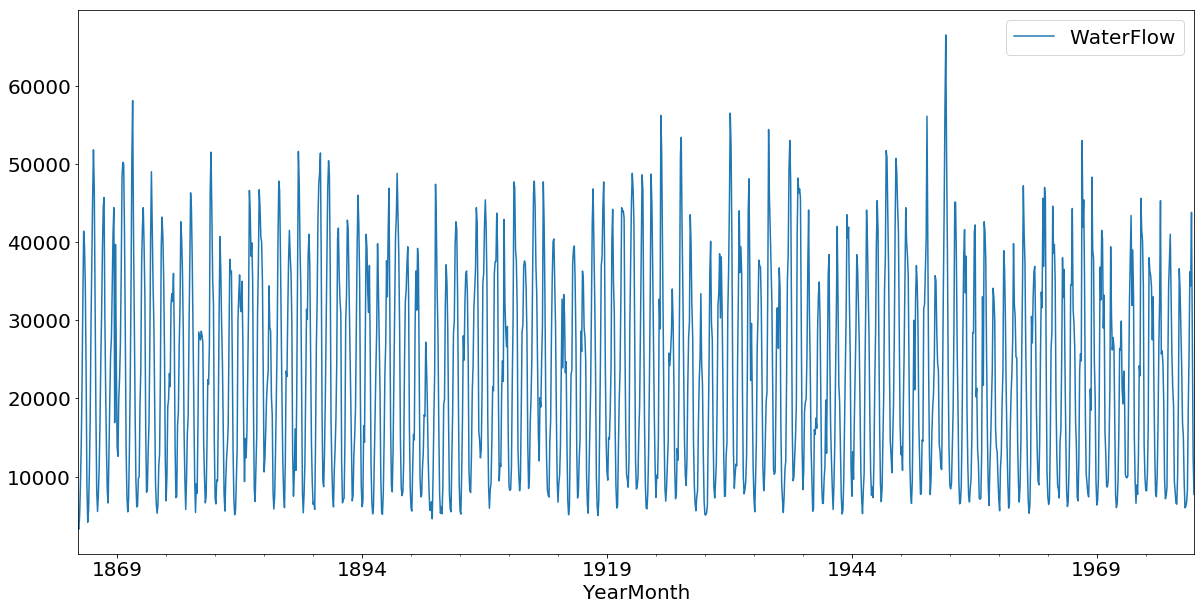

In [9]:
parser = lambda date: pd.datetime.strptime(date, '%Y-%m')
df1 = pd.read_csv(".././data/timeseries/monthly-flows-chang-jiang-at-hankou.csv", 
                 engine="python", skipfooter=3, names=["YearMonth", "WaterFlow"], 
                 parse_dates=[0], infer_datetime_format=True, date_parser=parser, 
                 header=0)
print(df1.head())
df1.YearMonth = pd.to_datetime(df1.YearMonth)
df1.set_index("YearMonth", inplace=True)
df1.plot()
plt.savefig('.././data/timeseries/WaterFlow.png')
plt.show()


第二个数据是1949年一月到1960年十二月的月度国际航空旅客数量。该数据有144个数据点，数据单位为千人，与第一个数据不同的是该数据包含极强的趋势要素和周期要素，因此在具体的分析上能体现不同的要求。该数据下载后在本地磁盘存为：.././data/TimeSeries/international-airline-passengers.csv 。下面我们读入该数据，并展示。

            Passenger
YearMonth            
1949-01-01        112
1949-02-01        118
1949-03-01        132
1949-04-01        129
1949-05-01        121


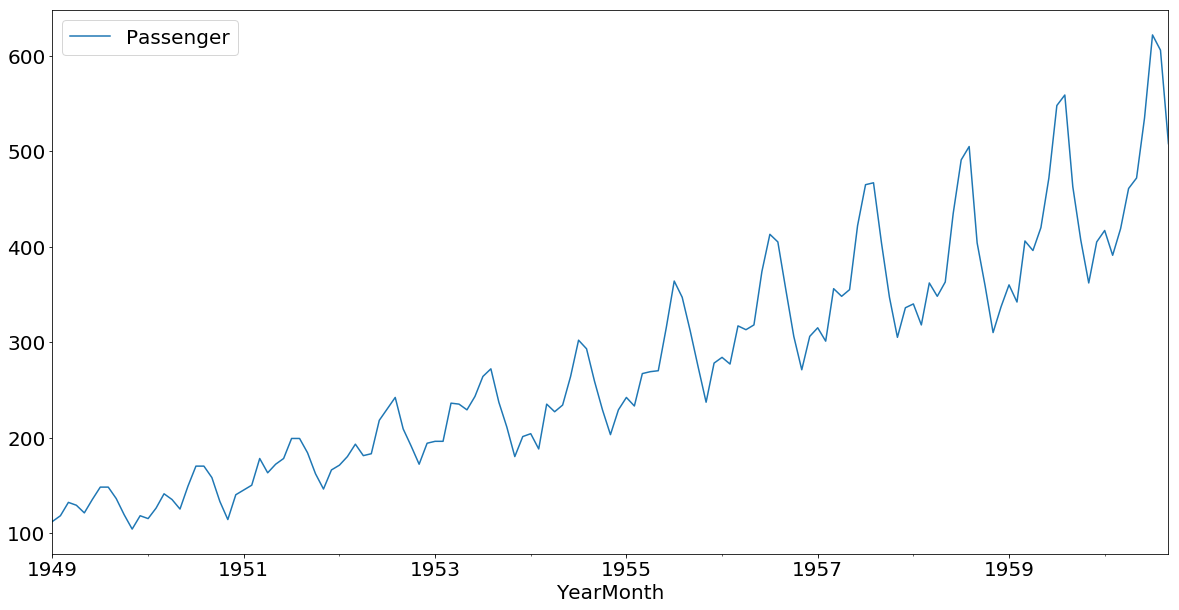

In [10]:
parser = lambda date: pd.datetime.strptime(date, '%b-%y')

df2 = pd.read_csv(".././data/timeseries/international-airline-passengers.csv", 
                 engine="python", skipfooter=3, names=["YearMonth", "Passenger"],                   
                 header=0)

df2.YearMonth = df2.YearMonth.str[:4]+'19'+df2.YearMonth.str[-2:]
df2.YearMonth = pd.to_datetime(df2.YearMonth, infer_datetime_format=True)
df2.set_index("YearMonth", inplace=True)
print(df2.head())
df2.plot(fontsize=20)
plt.savefig('.././data/timeseries/Passenger.png')
plt.show()
plt.close()

下面对数据的平稳性进行检验，使用ADF和KPSS两个统计测试量。同时生成其自相关和偏自相关图。需要注意的是KPSS测试在p值过小或者过大的情况下，会打印“警告”warnings信息。出于排版美观的要求，我们在下面的检验中，使用了warnings软件库里的catch_warnings方法来对KPSS函数的warnings打印信息进行控制，直接忽略不打印。

ADF test result on Difference shows test statistic is -3.045022 and p-value is 0.030898
ADF test result on Log Difference shows test statistic is -2.706950 and p-value is 0.072843
KPSS test result on Difference shows test statistic is 0.078160 and p-value is 0.100000
KPSS test result on Log difference shows test statistic is 0.059560 and p-value is 0.100000


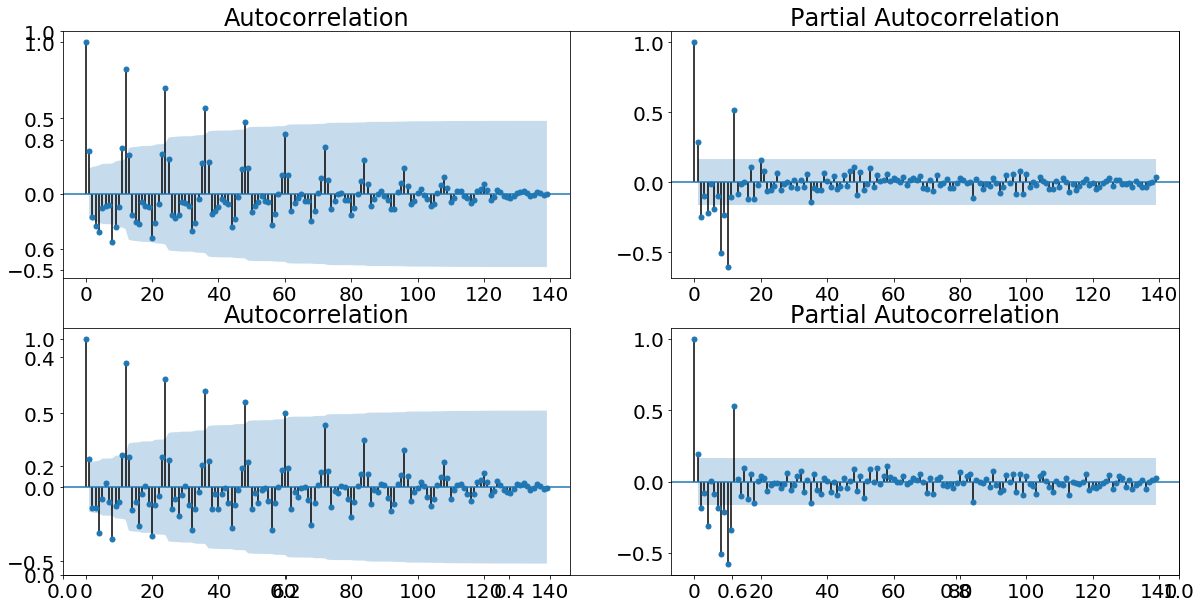

In [6]:
# test stationarity
order=1
diff1 = df2.Passenger.diff(order)[order:]
logdiff1 = np.log(df2.Passenger).diff(order)[order:]
adftest = sm.tsa.stattools.adfuller(diff1)
adftestlog = sm.tsa.stattools.adfuller(logdiff1)
print("ADF test result on Difference shows test statistic is %f \
and p-value is %f" %(adftest[:2]))
print("ADF test result on Log Difference shows test statistic is %f \
and p-value is %f" %(adftestlog[:2]))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    kpsstest = sm.tsa.stattools.kpss(diff1)
    kpsstestlog=sm.tsa.stattools.kpss(logdiff1)
    
print("KPSS test result on Difference shows test statistic is %f \
and p-value is %f" %(kpsstest[:2]))
print("KPSS test result on Log difference shows test statistic is %f \
and p-value is %f" %(kpsstestlog[:2]))

# compute and visualize ACF, PACF
fig, ax = plt.subplots()
ax1=fig.add_subplot(221)
sm.graphics.tsa.plot_acf(diff1, ax=ax1); 

ax2=fig.add_subplot(222)
sm.graphics.tsa.plot_pacf(diff1, ax=ax2); 

ax3 = fig.add_subplot(223)
sm.graphics.tsa.plot_acf(logdiff1, ax=ax3);

ax4=fig.add_subplot(224)
sm.graphics.tsa.plot_pacf(logdiff1, ax=ax4); 

plt.savefig('.././data/timeseries/ACF_PACF_diff1.png')
plt.show()

plt.close()

下面对长江汉口月度水量使用传统的SARIMA模型进行建模

In [7]:
def test_stationarity(timeseries, window=12): 
    df = pd.DataFrame(timeseries)
    df['Rolling.Mean'] = timeseries.rolling(window=window).mean()
    df['Rolling.Std']=timeseries.rolling(window=window).std()
    adftest = sm.tsa.stattools.adfuller(timeseries)
    adfoutput = pd.Series(adftest[0:4], index=['统计量','p-值 ','滞后量','观测值数量'])
    for key,value in adftest[4].items():
        adfoutput['临界值 (%s)'% key] = value
    return(adfoutput, df)

def CalculateCycle(ts, lags=36):  
    acf_x, acf_ci = acf(ts, alpha=0.05, nlags=lags)
    fs=1
    f, Pxx_den = signal.periodogram(acf_x, fs)
    
    index = peak.indexes(Pxx_den)
    cycle=(1/f[index[0]]).astype(int)
    fig = plt.figure()
    ax0 = fig.add_subplot(111)
    plt.vlines(f, 0, Pxx_den)
    plt.axhline(y=0)
    plt.plot(f[index], Pxx_den[index], marker='o', linestyle='none', color='red')
    plt.title("Identified Cycle of %i" % (cycle))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()
    return( index, f, Pxx_den)

原始数据平稳性检验
统计量            -5.147438
p-值             0.000011
滞后量            23.000000
观测值数量        1320.000000
临界值 (1%)       -3.435314
临界值 (5%)       -2.863732
临界值 (10%)      -2.567937
dtype: float64
局部数据平稳性检验
统计量           -2.943085
p-值            0.040562
滞后量           12.000000
观测值数量        179.000000
临界值 (1%)      -3.467420
临界值 (5%)      -2.877826
临界值 (10%)     -2.575452
dtype: float64
ADF test result shows test statistic is -13.013917 and p-value is 0.000000


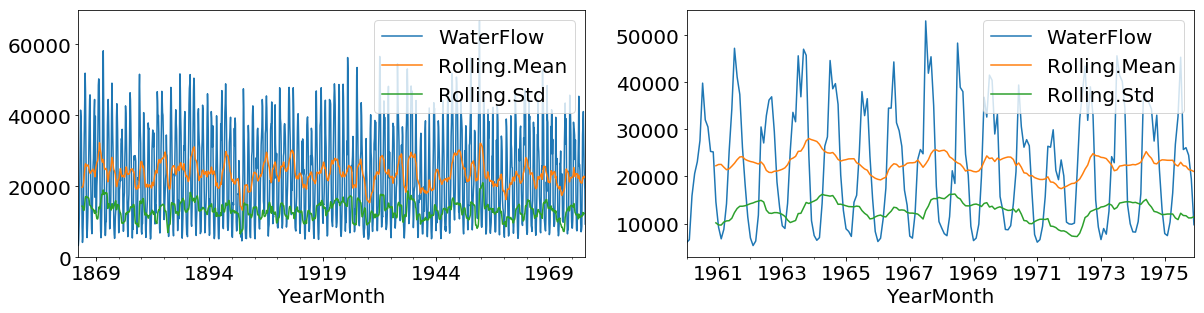

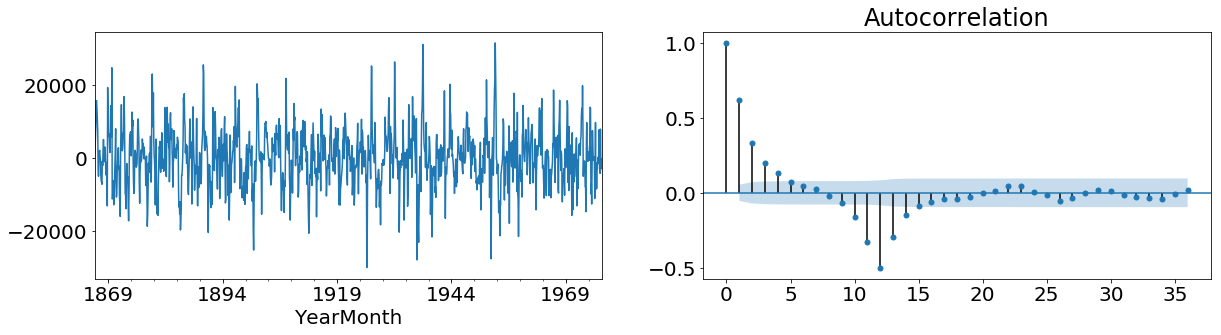

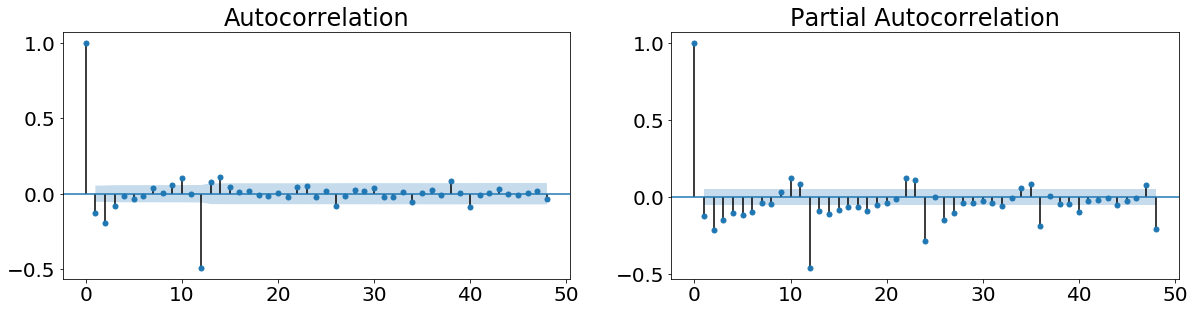

c:\Anaconda3\envs\cntkkeraspy35\lib\site-packages\numpy\linalg\linalg.py:1487: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


                                 Statespace Model Results                                 
Dep. Variable:                          WaterFlow   No. Observations:                 1344
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood              -13198.909
Date:                            Sun, 17 Sep 2017   AIC                          26401.819
Time:                                    13:49:27   BIC                          26412.226
Sample:                                01-01-1865   HQIC                         26405.717
                                     - 12-01-1976                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9474      0.009   -102.636      0.000      -0.965      -0.929
sigma2      2.368e+07   2.22e-11   

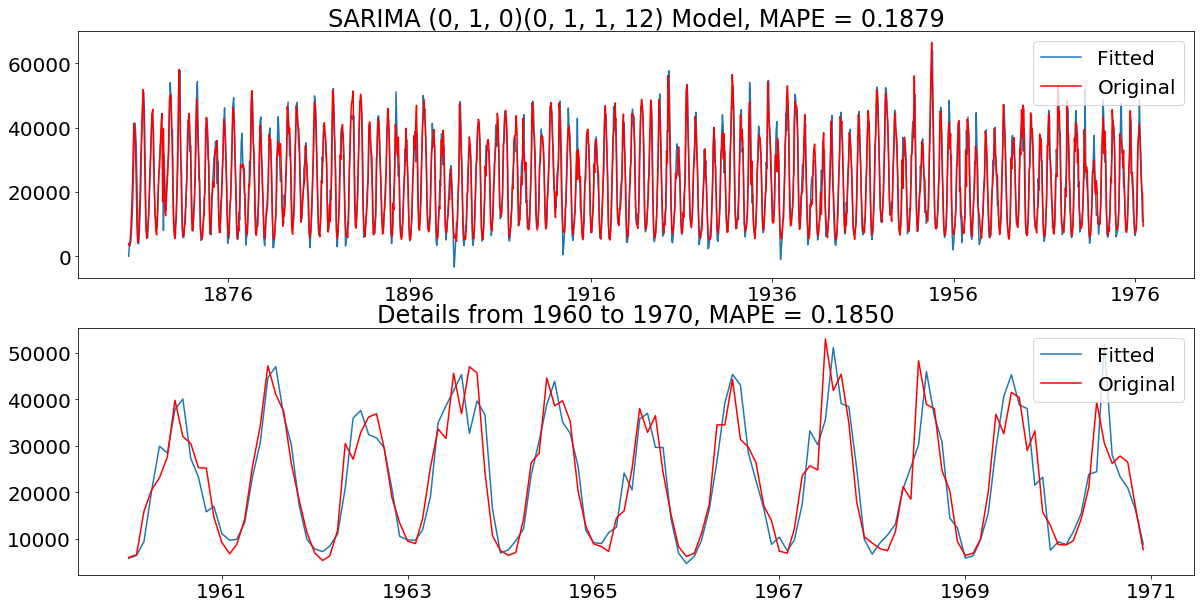

In [13]:
# build SARIMA model

cutoff=24
train = df1.WaterFlow[:-cutoff]
test = df1.WaterFlow[-cutoff:]
startYear = '1960'
endYear = '1975'

# check stationarity first
fig = plt.figure()
ax0 = fig.add_subplot(221)
adftest, dftest0=test_stationarity(train)
dftest0.plot(ax=ax0)
print('原始数据平稳性检验')
print(adftest)

ax1 = fig.add_subplot(222)
adftest, dftest1=test_stationarity(train[startYear:endYear])
dftest1.plot(ax=ax1)
print('局部数据平稳性检验')
print(adftest)


# test stationarity after removing seasonality
Seasonality=12
waterFlowS12 = train.diff(Seasonality)[Seasonality:]
waterFlowS12d1 = waterFlowS12.diff(1)[1:]
adftestS12 = sm.tsa.stattools.adfuller(waterFlowS12)
print("ADF test result shows test statistic is %f and p-value is %f" %(adftestS12[:2]))

nlag=36
xvalues = np.arange(nlag+1)

acfS12, confiS12 = sm.tsa.stattools.acf(waterFlowS12, nlags=nlag, alpha=0.05, fft=False)
confiS12 = confiS12 - confiS12.mean(1)[:,None]

fig = plt.figure()
ax0 = fig.add_subplot(221)
waterFlowS12.plot(ax=ax0)

ax1=fig.add_subplot(222)
sm.graphics.tsa.plot_acf(waterFlowS12, lags=nlag, ax=ax1)
plt.show()

fig = plt.figure()
ax0 = fig.add_subplot(221)
sm.graphics.tsa.plot_acf(waterFlowS12d1, ax=ax0, lags=48)
ax1 = fig.add_subplot(222)
sm.graphics.tsa.plot_pacf(waterFlowS12d1, ax=ax1, lags=48)
plt.show()

# Build SARIMA
arima_order1=(0,1,0)
season_order1=(0,1,1,12)
mod1 = sm.tsa.statespace.SARIMAX(train, trend='n', order=arima_order1, seasonal_order=season_order1).fit()
pred=mod1.predict()
print(mod1.summary())

# check validation results
subtrain = train['1960':'1970']
MAPE = (np.abs(train-pred)/train).mean()
subMAPE = (np.abs(subtrain-pred['1960':'1970'])/train).mean()

fig = plt.figure()
ax0 = fig.add_subplot(211)
plt.plot(pred, label='Fitted');
plt.plot(train, color='red', label='Original')
plt.legend(loc='best')
plt.title("SARIMA %s%s Model, MAPE = %.4f" % (arima_order1, season_order1, MAPE))

ax1 = fig.add_subplot(212)
plt.plot(pred['1960':'1970'], label='Fitted');
plt.plot(subtrain, color='red', label='Original')
plt.legend(loc='best')
plt.title("Details from 1960 to 1970, MAPE = %.4f" % subMAPE)
plt.show()

测试不同参数的SARIMA模型

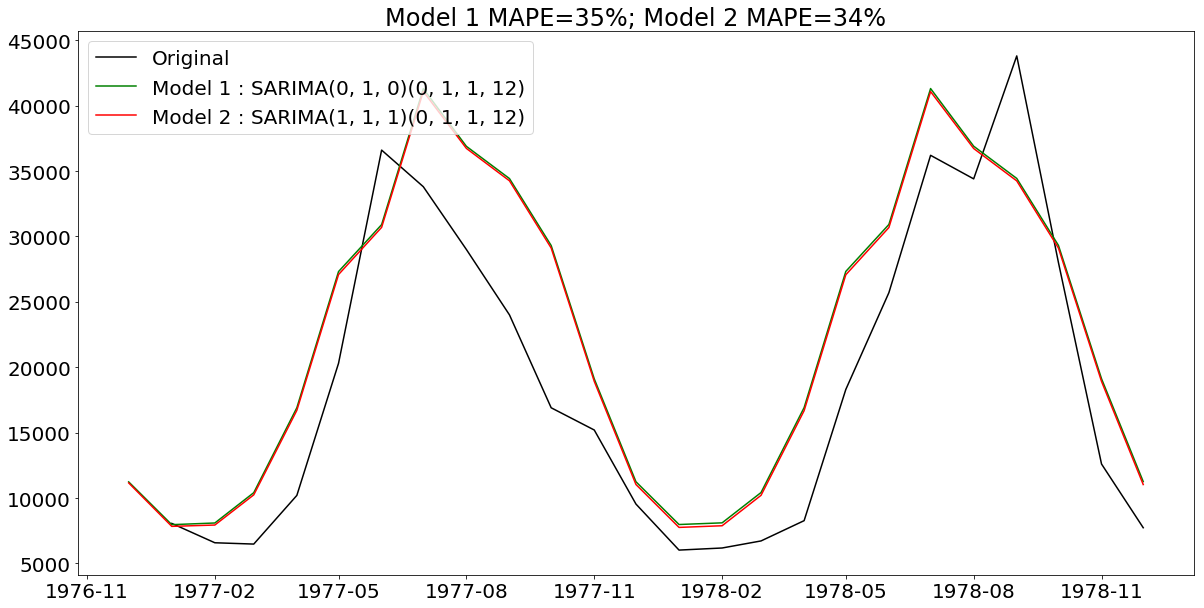

In [16]:
# test alternatives
arima_order2 = (1,1,1)
season_order2 = (0,1,1,12)
mod2 = sm.tsa.statespace.SARIMAX(train, trend='n', order=arima_order, seasonal_order=season_order).fit()
forecast1 = mod1.predict(start = '1976-12-01', end='1978' , dynamic= True)
forecast2 = mod2.predict(start = '1976-12-01', end='1978' , dynamic= True)
MAPE1 = ((test-forecast1).abs() / test).mean()*100
MAPE2 = ((test-forecast2).abs() / test).mean()*100

plt.plot(test, color='black', label='Original')
plt.plot(forecast1, color='green', label='Model 1 : SARIMA'+ str(arima_order1) + str(season_order1))
plt.plot(forecast2, color='red', label='Model 2 : SARIMA'+ str(arima_order2) + str(season_order2))
plt.legend(loc='best')
plt.title('Model 1 MAPE=%.f%%; Model 2 MAPE=%.f%%'%(MAPE1, MAPE2))

下面使用深度学习的LSTM模型对流量数据进行建模。首先定义数据生成函数。

In [8]:
from statsmodels.tsa.tsatools import lagmat

# define function to create data we need
def create_dataset(dataset, timestep=1, look_back=1, look_ahead=1):
    ds = dataset.reshape(-1, 1)    
    dataX = lagmat(dataset, maxlag=timestep*look_back, trim="both", original='ex')
    dataY = lagmat(dataset[(timestep*look_back):], maxlag=look_ahead, trim="backward", original='ex')
    # reshape and remove redundent rows
    dataX = dataX.reshape(dataX.shape[0], timestep, look_back)[:-(look_ahead-1)]
    return np.array(dataX), np.array(dataY[:-(look_ahead-1)])

检验该函数的正确性

In [11]:
temp = np.arange(100)+1
tempX, tempY = create_dataset(temp, timestep=3, look_back= 2, look_ahead=2)
print(tempY[-1, :])
print(tempX[-1, :, :])

[ 100.   99.]
[[ 98.  97.]
 [ 96.  95.]
 [ 94.  93.]]


进行数据准备工作

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
trainstd = scaler.fit_transform(train.values.astype(float).reshape(-1, 1))
teststd = scaler.transform(test.values.astype(float).reshape(-1, 1))

lookback=60
lookahead=24
timestep=1
trainX, trainY = create_dataset(trainstd, timestep=1, look_back=lookback, look_ahead=lookahead)
trainX = trainX.astype('float32')
trainY = trainY.astype('float32')

定义并训练我们的简单LSTM模型

In [20]:
# define LSTM model 
batch_size=1
model = kModels.Sequential()
model.add(kLayers.LSTM(48, batch_size=batch_size, input_shape=(1, lookback), kernel_initializer='he_uniform'))
model.add(kLayers.Dense(lookahead))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=batch_size, verbose=1)

Epoch 1/20
1261/1261 [==============================] - 16s - loss: 0.0129    
Epoch 2/20
1261/1261 [==============================] - 15s - loss: 0.0090    
Epoch 3/20
1261/1261 [==============================] - 15s - loss: 0.0087    
Epoch 4/20
1261/1261 [==============================] - 15s - loss: 0.0085    
Epoch 5/20
1261/1261 [==============================] - 15s - loss: 0.0084    
Epoch 6/20
1261/1261 [==============================] - 15s - loss: 0.0084    
Epoch 7/20
1261/1261 [==============================] - 15s - loss: 0.0083    
Epoch 8/20
1261/1261 [==============================] - 15s - loss: 0.0082    
Epoch 9/20
1261/1261 [==============================] - 16s - loss: 0.0081    
Epoch 10/20
1261/1261 [==============================] - 16s - loss: 0.0081    
Epoch 11/20
1261/1261 [==============================] - 15s - loss: 0.0080    
Epoch 12/20
1261/1261 [==============================] - 16s - loss: 0.0080    
Epoch 13/20
1261/1261 [==========================

下面使用训练后得到的模型进行预测并显示预测结果

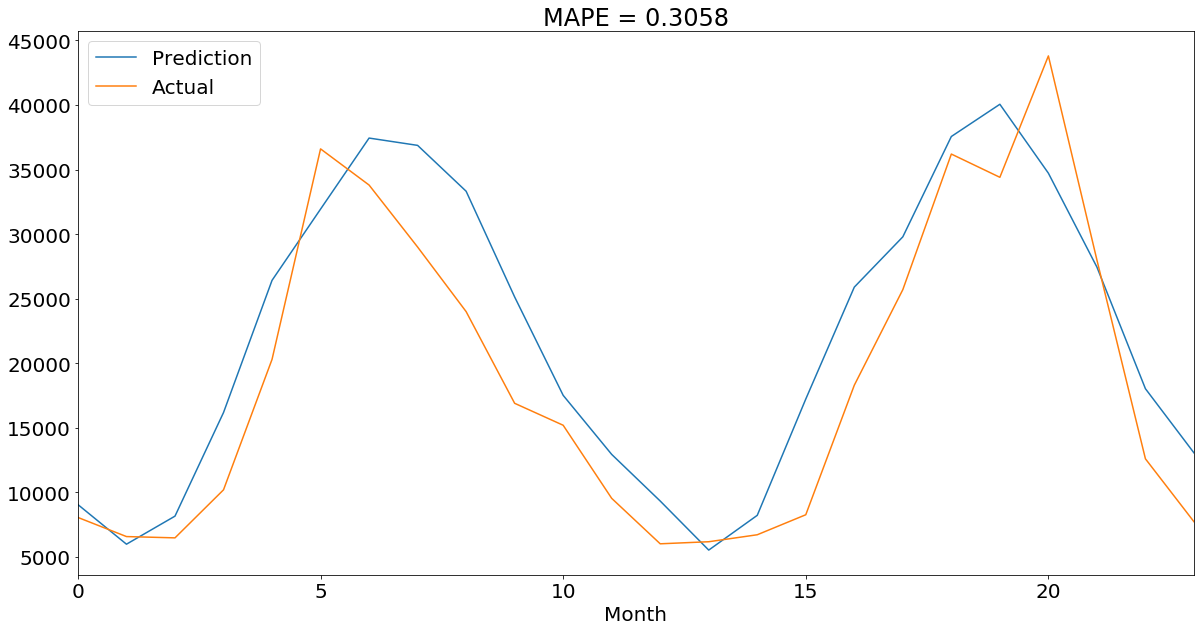

In [21]:
# visual 
feedData = scaler.transform(df1.WaterFlow['1972':'1976'].values.reshape(-1, 1)).copy()
feedX = (feedData).reshape(1, 1, lookback)
feedX = (feedX).astype('float32')
prediction1 = model.predict(feedX)

predictionRaw = scaler.inverse_transform(prediction1.reshape(-1, 1))
actual1 = df1.WaterFlow['1977':'1978'].copy().values.reshape(-1, 1)
MAPE = (np.abs(predictionRaw-actual1)/actual1).mean()

plt.plot(predictionRaw, label='Prediction')
plt.plot(actual1, label='Actual')
plt.title("MAPE = %.4f" % MAPE)
plt.legend(loc='best')
plt.xlim((0, 23))
plt.xlabel("Month")
plt.show()

叠加LSTM模型

Epoch 1/15
1261/1261 [==============================] - 0s - loss: 83.2315     
Epoch 2/15
1261/1261 [==============================] - 0s - loss: 68.6398     
Epoch 3/15
1261/1261 [==============================] - 0s - loss: 65.2094     
Epoch 4/15
1261/1261 [==============================] - 0s - loss: 62.1833     
Epoch 5/15
1261/1261 [==============================] - 0s - loss: 56.5165     
Epoch 6/15
1261/1261 [==============================] - 0s - loss: 45.2086     
Epoch 7/15
1261/1261 [==============================] - 0s - loss: 35.7862     
Epoch 8/15
1261/1261 [==============================] - 0s - loss: 33.1224     
Epoch 9/15
1261/1261 [==============================] - 0s - loss: 31.8217     
Epoch 10/15
1261/1261 [==============================] - 0s - loss: 31.3000     
Epoch 11/15
1261/1261 [==============================] - 0s - loss: 30.9273     
Epoch 12/15
1261/1261 [==============================] - 0s - loss: 30.5042     
Epoch 13/15
1261/1261 [==============

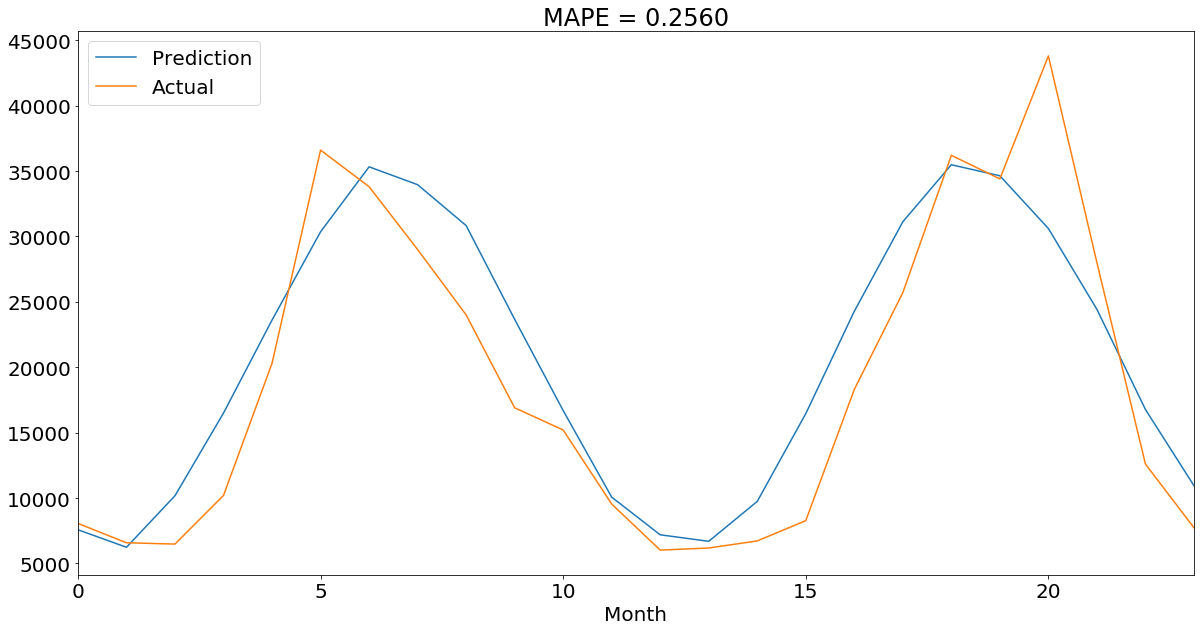

In [22]:
# create and fit the Stacked LSTM network
batch_size=100
model2 = kModels.Sequential()
model2.add(kLayers.LSTM(96, batch_size=batch_size, input_shape=(1, lookback), return_sequences=True))
model2.add(kLayers.Dropout(0.1))
model2.add(kLayers.LSTM(48))
model2.add(kLayers.Dense(lookahead))
model2.compile(loss='mape', optimizer='adam')
model2.fit(trainX, trainY, epochs=15, batch_size=batch_size, verbose=1)

# visual
feedData = df1.WaterFlow['1972':'1976'].copy()
feedX = scaler.transform(feedData.values.reshape(-1, 1)).reshape(1, 1, lookback).astype('float32')
prediction2 = model2.predict(feedX)
predictionRaw = scaler.inverse_transform(prediction2.reshape(-1, 1))
actual1 = df1.WaterFlow['1977':'1978'].copy().values.reshape(-1, 1)
MAPE = (np.abs(predictionRaw-actual1)/actual1).mean()

plt.plot(predictionRaw, label='Prediction')
plt.plot(actual1, label='Actual')
plt.title("MAPE = %.4f" % MAPE)
plt.legend(loc='best')
plt.xlim((0, 23))
plt.xlabel("Month")
plt.show()

不同程度的叠加LSTM

In [23]:
# stacked LSTM
def SLSTM(epoch=10, stacks=1, batchsize=5):
    batch_size=batchsize
    model2 = kModels.Sequential()
    model2.add(kLayers.LSTM(48, batch_size=batchsize, input_shape=(1, lookback), return_sequences=True))
    model2.add(kLayers.Dropout(0.1))
    for i in range(stacks-1):
        model2.add(kLayers.LSTM(32, return_sequences=True))
        model2.add(kLayers.Dropout(0.1))
        model2.add(kLayers.LSTM(32, return_sequences=False))
        model2.add(kLayers.Dense(lookahead))
        model2.compile(loss='mape', optimizer='adam')
        t0 = time()
        model2.fit(trainX, trainY, epochs=epoch, batch_size=batch_size, verbose=1)
        
        feedData = df1.WaterFlow['1972':'1976'].copy()
        feedX = scaler.transform(feedData.values.reshape(-1, 1)).reshape(1, 1, lookback).astype('float32')
        prediction2 = model2.predict(feedX)
        predictionRaw = scaler.inverse_transform(prediction2.reshape(-1, 1))
        actual1 = df1.WaterFlow['1977':'1978'].copy().values.reshape(-1, 1)
        deltatime = time()-t0
        MAPE = (np.abs(predictionRaw-actual1)/actual1).mean()
        print("Epoch= %.1f, MAPE=%.5f, 消耗时间=%.4f 秒" % (epoch, MAPE, deltatime))

In [24]:
for epoch in [4,5,6,7,8,9,10]:
    SLSTM(epoch, stacks=2, batchsize=5)

Epoch 1/4
1261/1261 [==============================] - 10s - loss: 64.0405    
Epoch 2/4
1261/1261 [==============================] - 10s - loss: 35.1461    
Epoch 3/4
1261/1261 [==============================] - 10s - loss: 31.6753    
Epoch 4/4
1261/1261 [==============================] - 10s - loss: 30.6181    
Epoch= 4.0, MAPE=0.19898, 消耗时间=42.1534 秒


c:\Anaconda3\envs\cntkkeraspy35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Epoch 1/5
1261/1261 [==============================] - 10s - loss: 65.7885    
Epoch 2/5
1261/1261 [==============================] - 10s - loss: 36.3439    
Epoch 3/5
1261/1261 [==============================] - 10s - loss: 31.8024    
Epoch 4/5
1261/1261 [==============================] - 10s - loss: 30.6881    
Epoch 5/5
1261/1261 [==============================] - 10s - loss: 30.0631    
Epoch= 5.0, MAPE=0.25743, 消耗时间=51.9132 秒
Epoch 1/6
1261/1261 [==============================] - 10s - loss: 65.4807    
Epoch 2/6
1261/1261 [==============================] - 10s - loss: 35.7416    
Epoch 3/6
1261/1261 [==============================] - 10s - loss: 32.2553    
Epoch 4/6
1261/1261 [==============================] - 10s - loss: 31.0270    
Epoch 5/6
1261/1261 [==============================] - 10s - loss: 30.2525    
Epoch 6/6
1261/1261 [==============================] - 10s - loss: 29.7930    
Epoch= 6.0, MAPE=0.29421, 消耗时间=62.2064 秒
Epoch 1/7
1261/1261 [============================

下面我们使用国际航空旅客数量作为例子来展示ARIMA模型的建模过程。使用这个数据是因为从图像上看这个数据具有很强的趋势和周期性，因此能够充分展示建模的不同步骤。

原始数据平稳性检验
统计量           -0.773461
p-值            0.826794
滞后量           13.000000
观测值数量        106.000000
临界值 (1%)      -3.493602
临界值 (5%)      -2.889217
临界值 (10%)     -2.581533
dtype: float64
局部数据平稳性检验


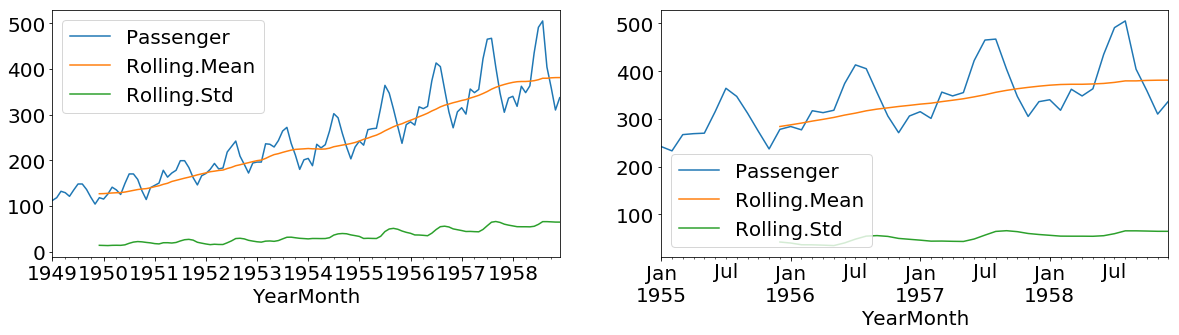

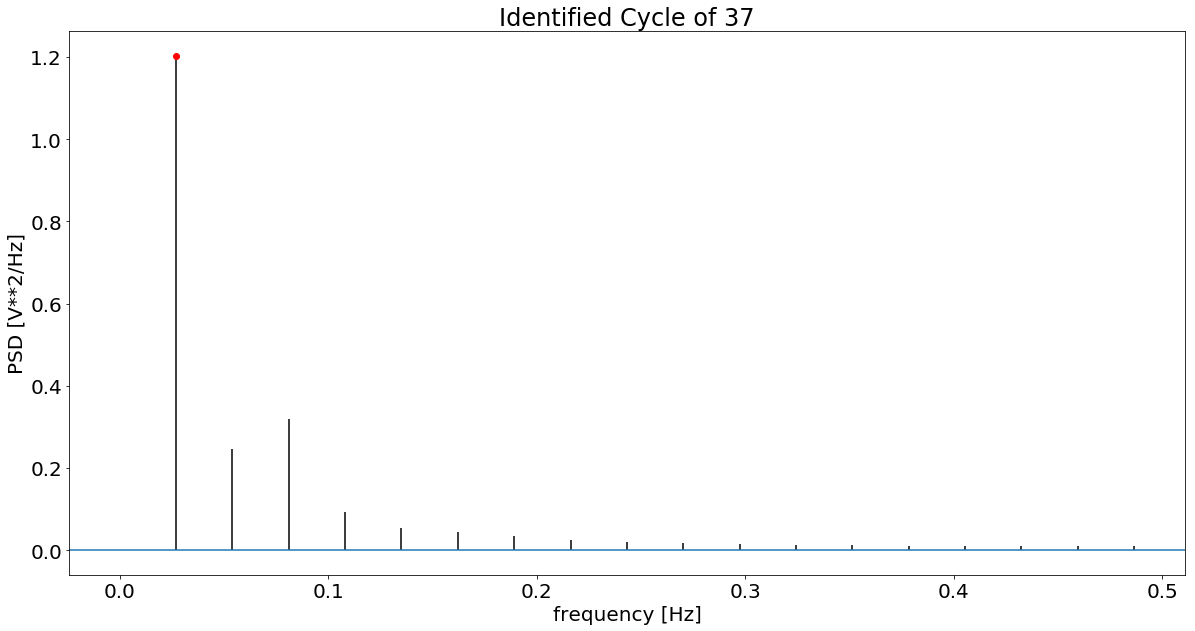

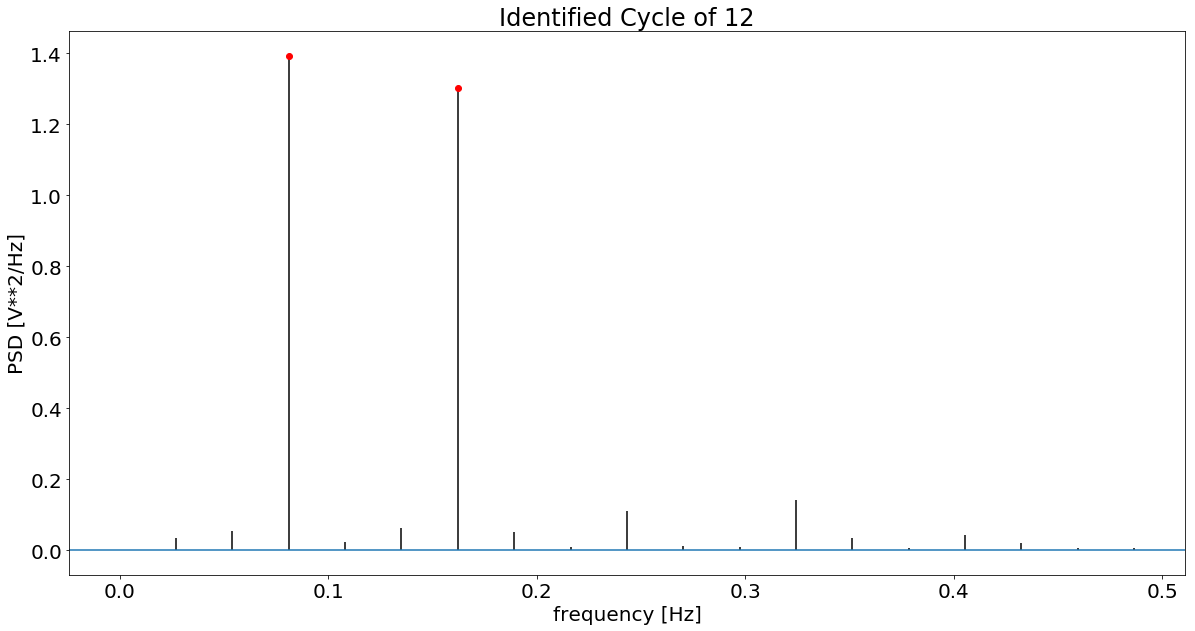

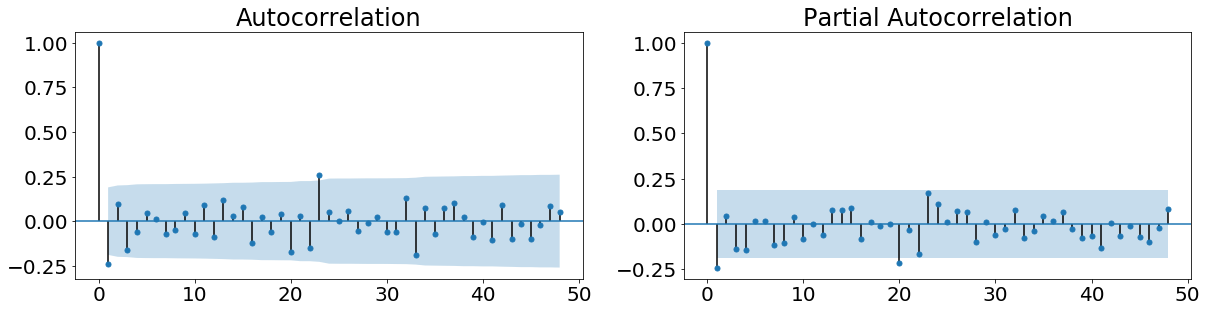

In [29]:

# model international passensger data
cutoff=21
train2 = df2.Passenger[:-cutoff]
test2 = df2.Passenger[-cutoff:]

fig = plt.figure()
ax0 = fig.add_subplot(221)
adftest, dftest0=test_stationarity(train2)
dftest0.plot(ax=ax0)
print('原始数据平稳性检验')
print(adftest)

ax1 = fig.add_subplot(222)
adftest, dftest1=test_stationarity(train2['1955':'1960'])
dftest1.plot(ax=ax1)
print('局部数据平稳性检验')

# identify cycle
index, f, Power = CalculateCycle(train2)

train2d1 = train2.diff(1)[1:]
index, f, Power = CalculateCycle(train2d1)

season=12
train2d1s12 = train2d1.diff(season)[season:]

nlags=48
fig = plt.figure()
ax0 = fig.add_subplot(221)
sm.graphics.tsa.plot_acf(train2d1s12, ax=ax0, lags=48)
ax1 = fig.add_subplot(222)
sm.graphics.tsa.plot_pacf(train2d1s12, ax=ax1, lags=48)
plt.show()

下面来拟合SARIMA模型

In [79]:
# fit a seasonal ARIMA model 
arima_order3 = (0,1,0)
season_order3 = (1,1,0,12)
mod1 = sm.tsa.statespace.SARIMAX(train2, trend='c', order=arima_order3, seasonal_order=season_order3).fit()
pred=mod1.predict()
print(mod1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Passenger   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -402.338
Date:                            Sun, 17 Sep 2017   AIC                            810.677
Time:                                    14:53:56   BIC                            819.039
Sample:                                01-01-1949   HQIC                           814.073
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0204      1.026     -0.020      0.984      -2.031       1.990
ar.S.L12      -0.1020      0.085   

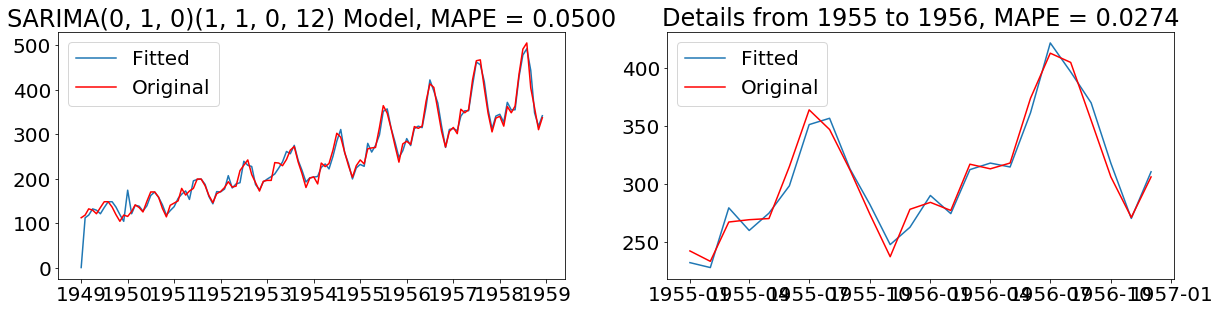

In [31]:
subtrain = train2['1955':'1956']
MAPE = (np.abs(train2-pred)/train2).mean()
subMAPE = (np.abs(subtrain-pred['1955':'1956'])/train2).mean()

fig = plt.figure()
ax0 = fig.add_subplot(221)
plt.plot(pred, label='Fitted'); 
plt.plot(train2, color='red', label='Original')
plt.legend(loc='best')
plt.title("SARIMA%s%s Model, MAPE = %.4f" % (arima_order3, season_order3, MAPE))

ax1 = fig.add_subplot(222)
plt.plot(pred['1955':'1956'], label='Fitted'); 
plt.plot(subtrain, color='red', label='Original')
plt.legend(loc='best')
plt.title("Details from 1955 to 1956, MAPE = %.4f" % subMAPE)

plt.savefig(".././data/timeseries/Flight_SARIMA_plot.png")
plt.show()

12.3711331531


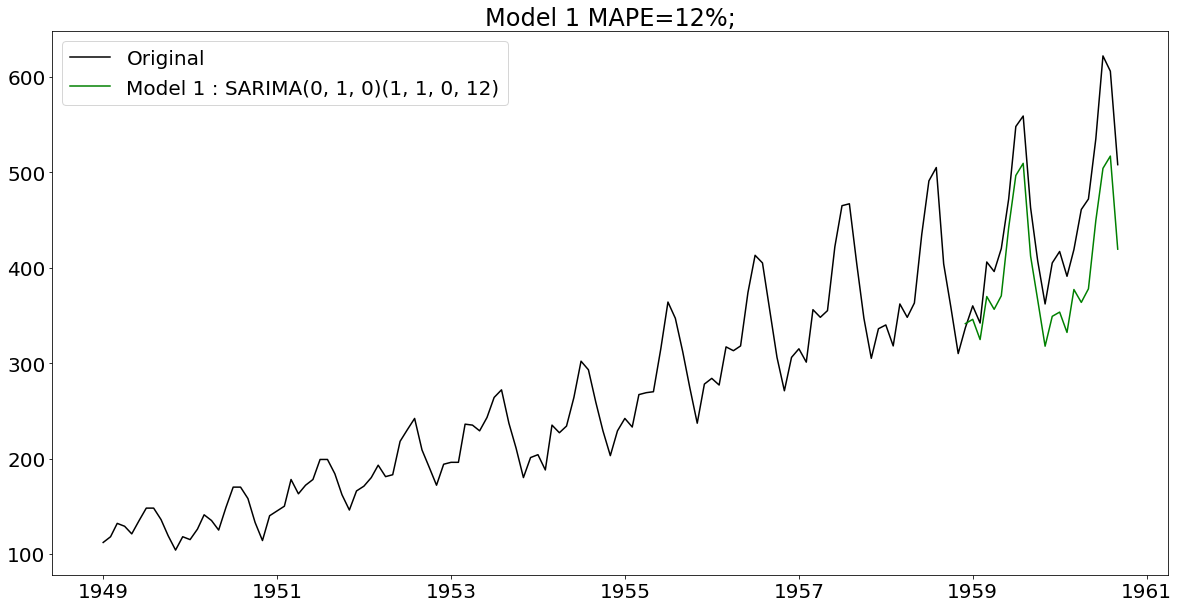

In [32]:
forecast1 = mod1.predict(start = '1958-12-01', end='1960-09-01' , dynamic= True) 
MAPE1 = ((test2-forecast1[1:]).abs() / test2).mean()*100
print(MAPE1)

plt.plot(df2, color='black', label='Original')
plt.plot(forecast1, color='green', label='Model 1 : SARIMA' + str(arima_order3) + str(season_order3))
plt.legend(loc='best')
plt.title('Model 1 MAPE=%.f%%;' %(MAPE1))

plt.savefig(".././data/timeseries/Flight_SARIMA_pred.png")

下面为LSTM模型准备数据

In [81]:
scaler = MinMaxScaler(feature_range=(0, 1))
trainstd2 = scaler.fit_transform(train2.values.astype(float).reshape(-1, 1))
teststd2 = scaler.transform(test2.values.astype(float).reshape(-1, 1))

In [82]:
lookback=60
lookahead=24
timestep=1
trainX2, trainY2 = create_dataset(trainstd2, timestep=1, look_back=lookback, look_ahead=lookahead)
trainX2 = trainX2.astype('float32')
trainY2 = trainY2.astype('float32')

In [83]:
%%time
# build LSTM 
batch_size=1
model = kModels.Sequential()
model.add(kLayers.LSTM(96, batch_size=batch_size, input_shape=(1, lookback), kernel_initializer='he_uniform'))
#model.add(kLayers.Dense(32))
model.add(kLayers.Dense(lookahead))
#model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mape', optimizer='adam')
model.fit(trainX2, trainY2, epochs=30, batch_size=batch_size, verbose=0)

Wall time: 14.8 s


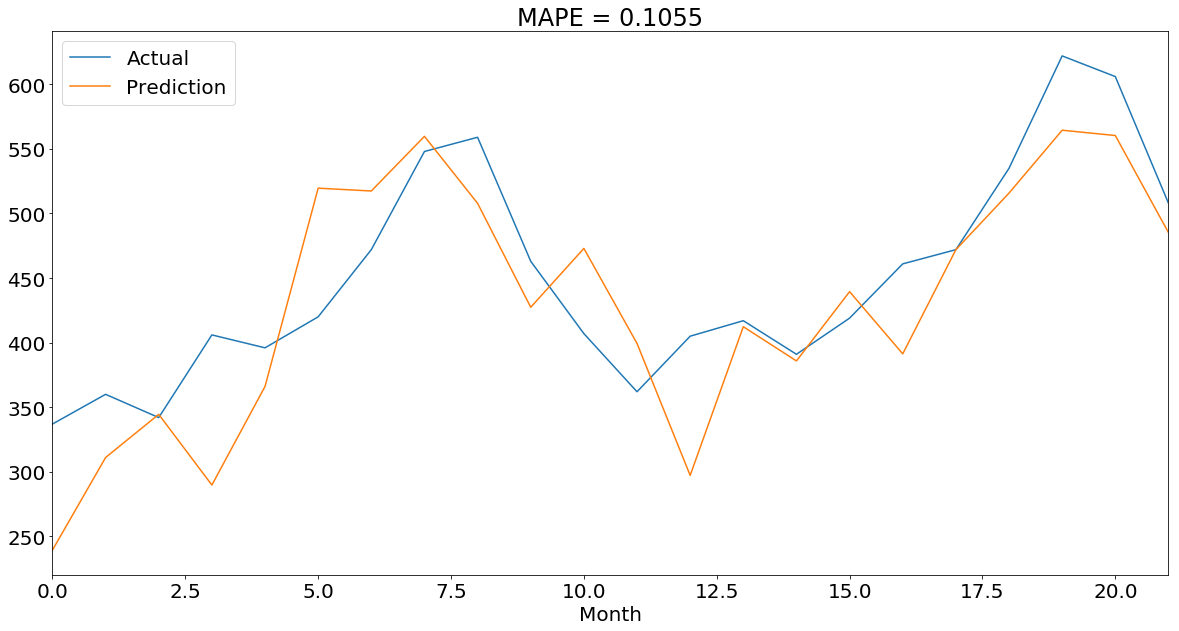

In [84]:
feedData = scaler.transform(df2.Passenger['1954-01-01':'1958-12-01'].values.reshape(-1, 1)).copy()
feedX = (feedData).reshape(1, 1, lookback)
feedX = (feedX).astype('float32')
prediction1 = model.predict(feedX)
#prediction1.shape

predictionRaw = scaler.inverse_transform(prediction1.reshape(-1, 1))[:-2]
#predictionRaw = (prediction1.reshape(-1, 1))
actual1 = df2.Passenger['1958-12-01':'1960-09-01'].copy().values.reshape(-1, 1)
MAPE = (np.abs(predictionRaw-actual1)/actual1).mean()
plt.plot(actual1, label='Actual')
plt.plot(predictionRaw, label='Prediction')
plt.title("MAPE = %.4f" % MAPE)
plt.legend(loc='best')
plt.xlim((0, 21))
plt.xlabel("Month")

plt.savefig(".././data/timeseries/Flight_LSTM_pred.png")
plt.show()

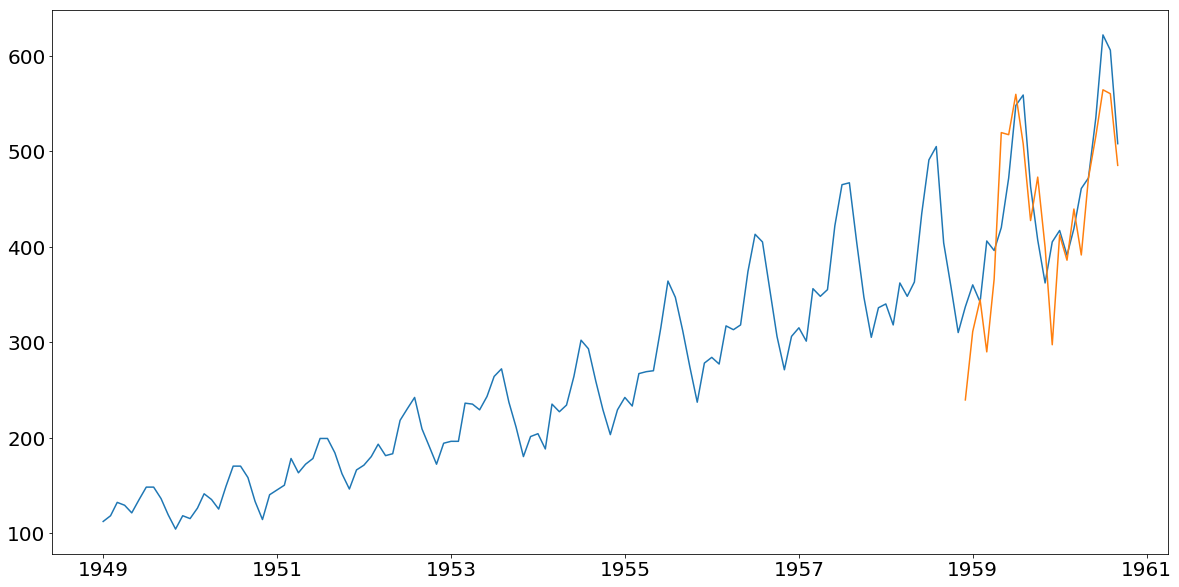

In [85]:
predAll=df2.Passenger*np.nan
predAll[-22:] = predictionRaw.reshape(-1)
plt.plot(df2.Passenger)
plt.plot(predAll)
plt.show()

使用消除异方差的数据建模

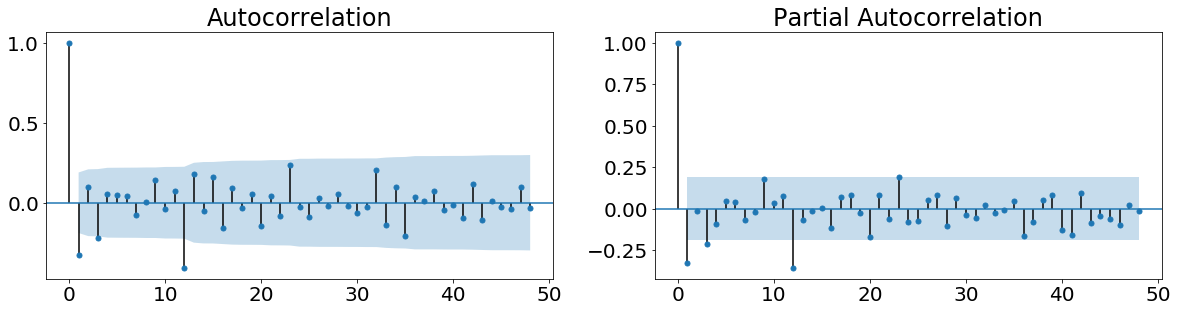

                                 Statespace Model Results                                 
Dep. Variable:                          Passenger   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(2, 1, 1, 12)   Log Likelihood                 192.159
Date:                            Sun, 17 Sep 2017   AIC                           -376.318
Time:                                    14:57:22   BIC                           -365.168
Sample:                                01-01-1949   HQIC                          -371.790
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0850      0.421     -0.202      0.840      -0.909       0.739
ar.S.L24      -0.0912      0.212   

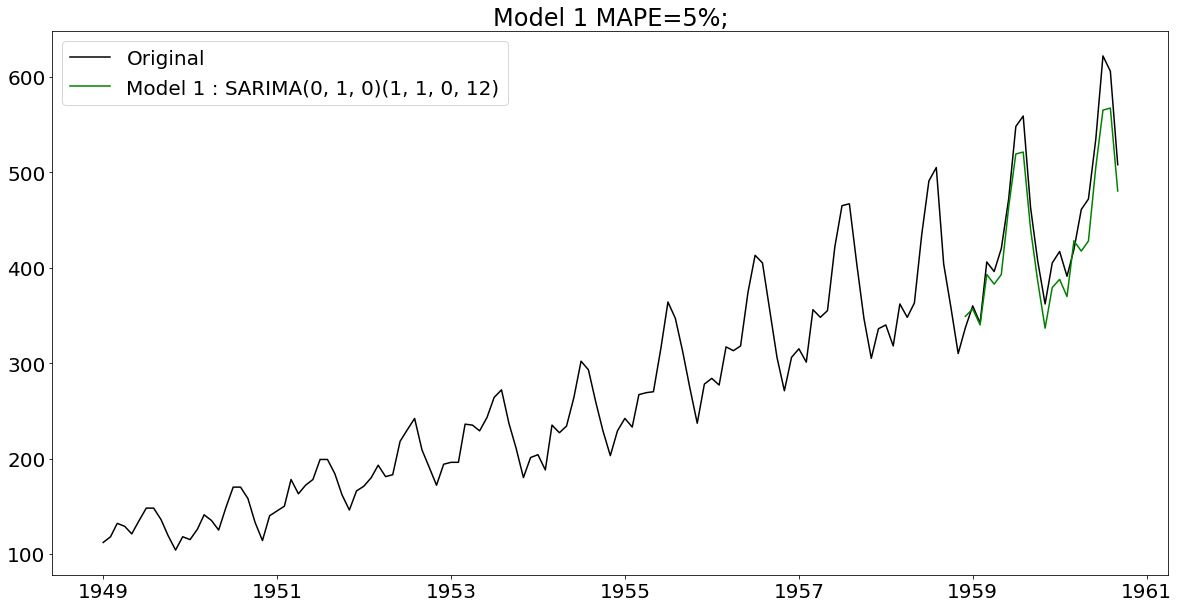

In [86]:
train2log = np.log(train2)
test2log = np.log(test2)

train2logd1s12 = (train2log.diff(1)[1:]).diff(12)[12:]
fig = plt.figure()
ax0 = fig.add_subplot(221)
sm.graphics.tsa.plot_acf(train2logd1s12, ax=ax0, lags=48)

ax1 = fig.add_subplot(222)
sm.graphics.tsa.plot_pacf(train2logd1s12, ax=ax1, lags=48)
plt.savefig(".././data/timeseries/Flight_log_ACF_PACF.png")
plt.show()
plt.close()


mod1 = sm.tsa.statespace.SARIMAX(train2log, trend='n', order=(0,1,0), seasonal_order=(2,1,1,12)).fit()
pred=mod1.predict()
print(mod1.summary())

forecast1 = mod1.predict(start = '1958-12-01', end='1960-09-01' , dynamic= True) 
forecast1 = np.exp(forecast1)
MAPE1 = ((test2-forecast1[1:]).abs() / test2).mean()*100
print(MAPE1)

plt.plot(df2, color='black', label='Original')
plt.plot(forecast1, color='green', label='Model 1 : SARIMA' + str(arima_order3) + str(season_order3))
plt.legend(loc='best')
plt.title('Model 1 MAPE=%.f%%;' %(MAPE1))

plt.savefig(".././data/timeseries/Flight_log_SARIMA_pred.png")
plt.show()
plt.close()

In [94]:
%%time
scaler2 = MinMaxScaler(feature_range=(0, 1))
trainlogstd2 = scaler2.fit_transform(train2log.values.astype(float).reshape(-1, 1))
testlogstd2 = scaler2.transform(test2log.values.astype(float).reshape(-1, 1))  

lookback=60
lookahead=24
timestep=1, 
trainlogX2, trainlogY2 = create_dataset(trainlogstd2, timestep=1, look_back=lookback, look_ahead=lookahead)
trainlogX2 = trainlogX2.astype('float32')
trainlogY2 = trainlogY2.astype('float32')

batch_size=10
model = kModels.Sequential()
model.add(kLayers.LSTM(96, input_shape=(1, lookback), kernel_initializer='he_uniform'))
model.add(kLayers.Dense(lookahead))
model.compile(loss='mape', optimizer='adam')
model.fit(trainlogX2, trainlogY2,  epochs=60, batch_size=batch_size, verbose=1)

Epoch 1/60
37/37 [==============================] - 0s - loss: 87.6246     
Epoch 2/60
37/37 [==============================] - 0s - loss: 73.3754     
Epoch 3/60
37/37 [==============================] - 0s - loss: 57.6252     
Epoch 4/60
37/37 [==============================] - 0s - loss: 41.4238     
Epoch 5/60
37/37 [==============================] - 0s - loss: 29.2034     
Epoch 6/60
37/37 [==============================] - 0s - loss: 23.0414     
Epoch 7/60
37/37 [==============================] - 0s - loss: 17.3627     
Epoch 8/60
37/37 [==============================] - 0s - loss: 14.1684     
Epoch 9/60
37/37 [==============================] - 0s - loss: 12.8618     
Epoch 10/60
37/37 [==============================] - 0s - loss: 12.1986     
Epoch 11/60
37/37 [==============================] - 0s - loss: 11.5139     
Epoch 12/60
37/37 [==============================] - 0s - loss: 11.0204     
Epoch 13/60
37/37 [==============================] - 0s - loss: 10.4825     
Epoch 14

对数变换以后深度学习模型的预测效果较差。

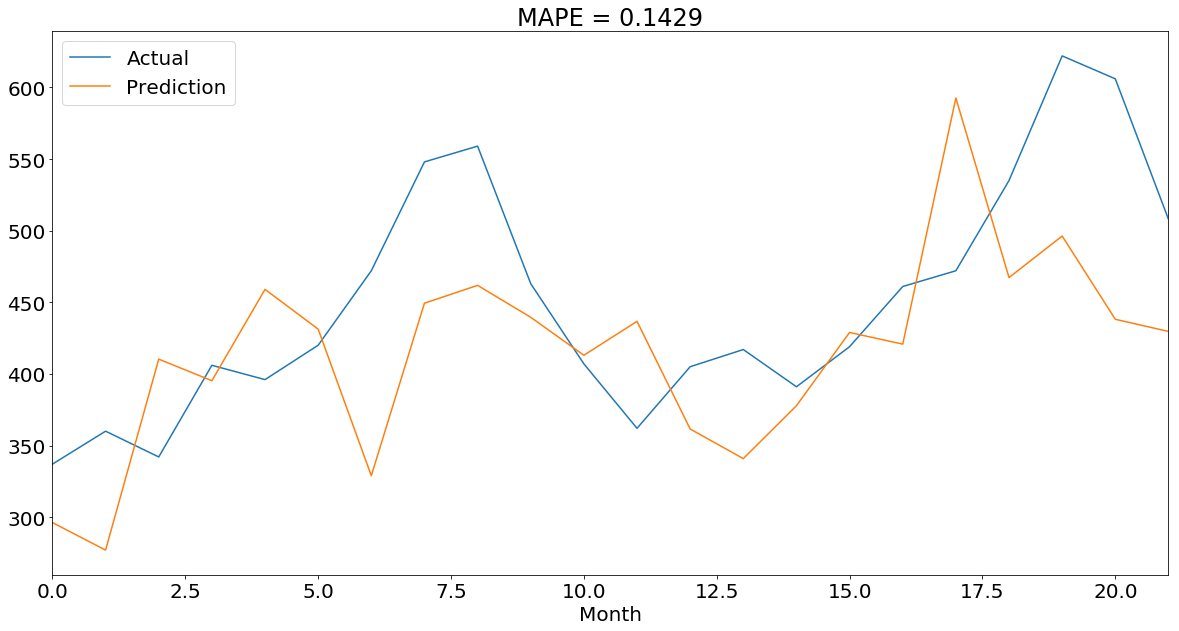

In [99]:
feedData = df2.Passenger['1954-01-01':'1958-12-01'].values.reshape(-1, 1).copy()
feedData = np.log(feedData)
feedData = scaler2.transform(feedData)
feedX = (feedData).reshape(1, 1, lookback).astype('float32')
prediction1 = model.predict(feedX)
#prediction1.shape

prediction1 = scaler2.inverse_transform(prediction1.reshape(-1, 1))[:-2]
#predictionRaw = (prediction1).reshape(-1, 1)
predictionRaw = np.exp(prediction1.reshape(-1, 1))
actual1 = df2.Passenger['1958-12-01':'1960-09-01'].copy().values.reshape(-1, 1)
MAPE = (np.abs(predictionRaw[:]-actual1)/actual1).mean()
plt.plot(actual1, label='Actual')
plt.plot(predictionRaw, label='Prediction')
plt.title("MAPE = %.4f" % MAPE)
plt.legend(loc='best')
plt.xlim((0, 21))
plt.xlabel("Month")
plt.show()

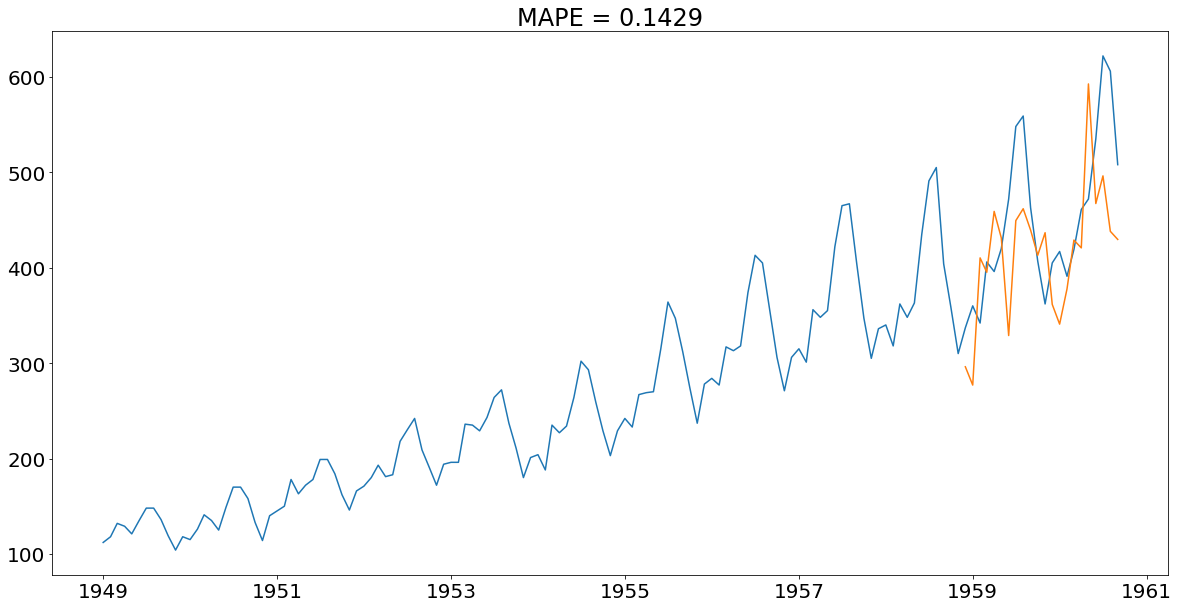

In [100]:
predAll=df2.Passenger*np.nan
predAll[-22:] = predictionRaw.reshape(-1)
plt.plot(df2.Passenger)
plt.plot(predAll)
plt.title("MAPE = %.4f" % MAPE)
plt.show()

# 带自变量的LSTM模型

如果带有自变量，该如何用LSTM来建模呢？该如何组织数据呢？我们下面举一个简单的股价预测模型。

In [3]:
import time
try:
    from  pandas_datareader import data
except ImportError:
    !pip install pandas_datareader
    from  pandas_datareader import data 
    
try:
    import datetime
except ImportError:
    !pip install datetime
    import datetime
    
def get_stock_data(contract, s_year, s_month, s_day, e_year, e_month, e_day):
    """
    code borrowed from CNTK example, default to YAHOO backend
    Args:
        contract (str): the name of the stock/etf
        s_year (int): start year for data
        s_month (int): start month
        s_day (int): start day
        e_year (int): end year
        e_month (int): end month
        e_day (int): end day
    Returns:
        Pandas Dataframe: Daily OHLCV bars
    """
    start = datetime.datetime(s_year, s_month, s_day)
    end = datetime.datetime(e_year, e_month, e_day)
    
    retry_cnt, max_num_retry = 0, 10
    
    while(retry_cnt < max_num_retry):
        try:
            bars = data.DataReader(contract,"yahoo", start, end)
            return bars
        except:
            retry_cnt += 1
            time.sleep(np.random.randint(1,10)) 
            
    print("Yahoo Finance is not reachable")
    raise Exception('Yahoo Finance is not reachable')

In [4]:
import pandas_datareader as pdr
msft=get_stock_data('MSFT', 2006, 1, 1, 2017, 11, 1)

下面看看过去一年微软股票的走势。

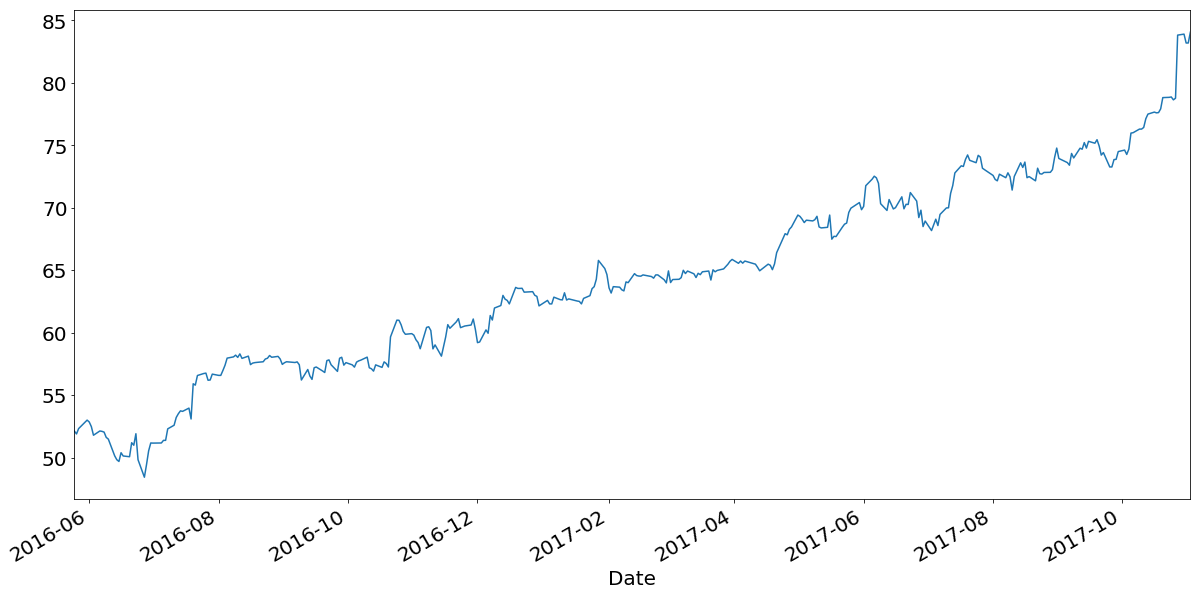

In [5]:
msft.Close[-365:].plot()
plt.show()

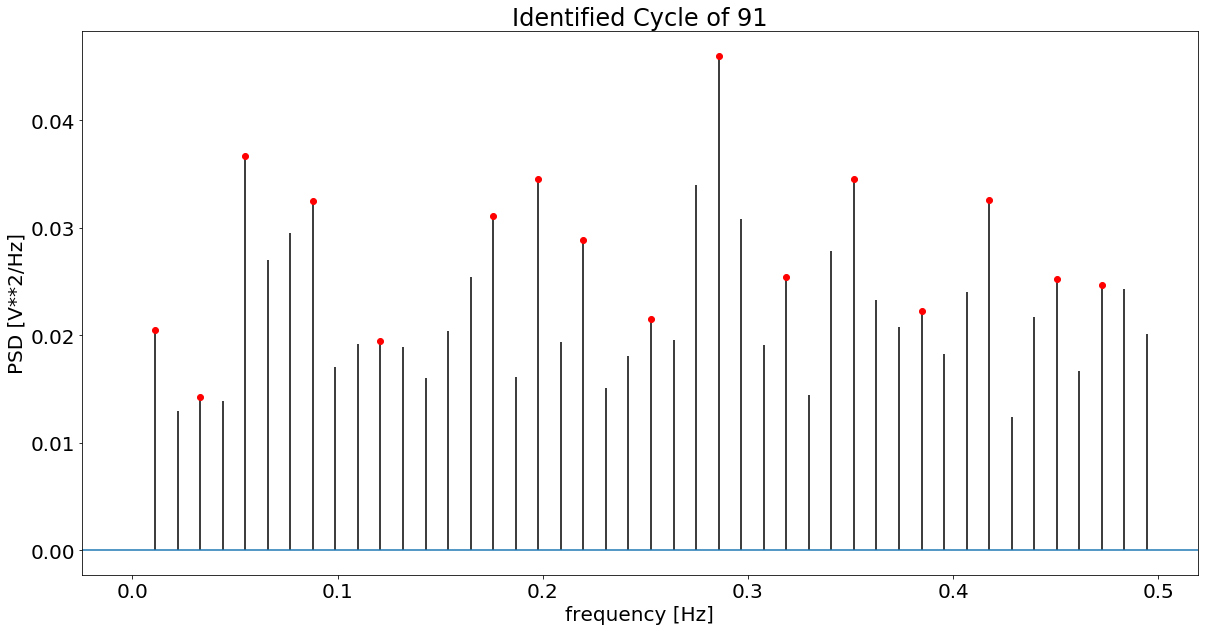

In [13]:
index, f, power = CalculateCycle(msft.Close.diff(1)[1:], lags=90)

In [14]:
1/f[index]

array([ 91.        ,  30.33333333,  18.2       ,  11.375     ,
         8.27272727,   5.6875    ,   5.05555556,   4.55      ,
         3.95652174,   3.5       ,   3.13793103,   2.84375   ,
         2.6       ,   2.39473684,   2.2195122 ,   2.11627907])

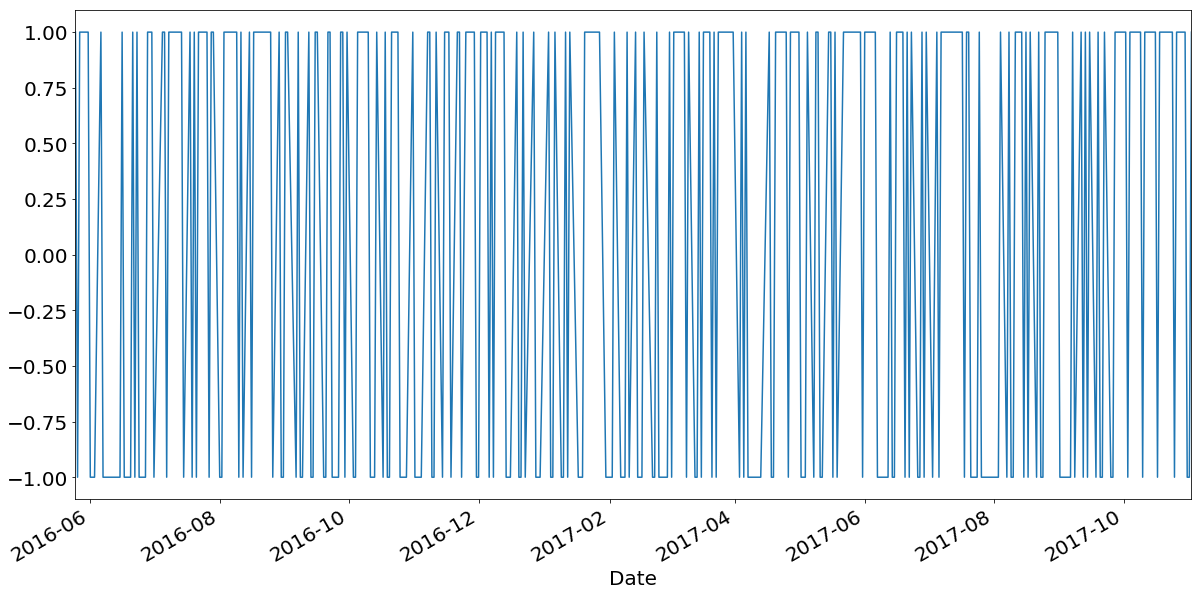

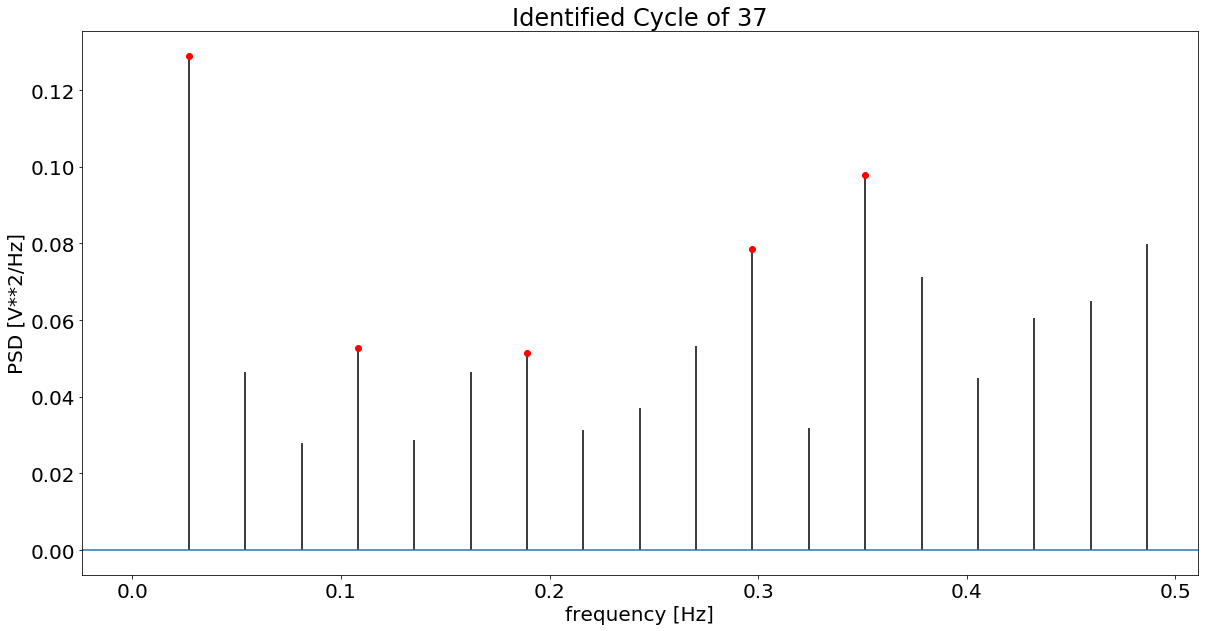

In [9]:
b=(msft.Close.diff(1)[-365:]>0)*2-1
b.plot()
index, f, power = CalculateCycle(b)

In [30]:
1/f[index]

array([ 37.        ,   9.25      ,   5.28571429,   3.36363636,   2.84615385])

我们准备用过去7天的股价和其他量价数据来预测明天的收盘价。这个模型并不具有真实的经济含义和预测能力，主要是用来展示如何在LSTM里面引入随时间变化的外生变量。

一般来讲，股价的预测是通过对于股票的日均回报率时间序列进行建模来实现的。

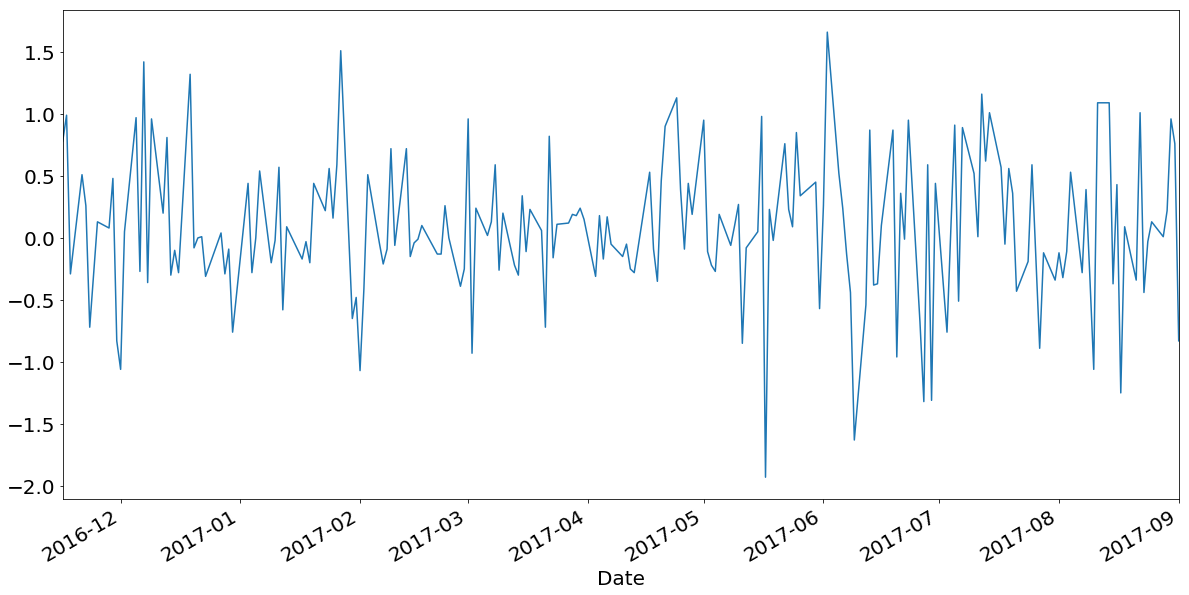

In [14]:
msft.Close.diff(1)[-200:].plot()

In [15]:
Y = msft.Close.shift(1)

我们现在来构造特征向量。处于展示的目的，我们假设特征值是过去7天的交易量和收盘价，待预测的是未来2天的涨跌情况。这里7和2只是随意设定的值，读者可以试试别的参数值。

为了有效构造多输入变量的张量供LSTM模型使用，原来的create_dataset函数需要进行修改。在原来的函数里，我们使用了statsmodel库里的lagmat函数，这里我们需要自己直接在原有的矩阵上进行对下标进行操作。

目标数据集的格式为一个三维的张量，其中第一维是代表样本，第二维代表时间步（或者说是往回看的时间），第三维则是每个时间步对应的当期特征向量值，比如在这个股票数据里就为对应时间t的交易量，时间t的收盘价，时间t-1的收盘价等。

In [ ]:
def create_dataset3(Xdf, Ydf, timesteps=1, look_ahead=1):
    X =  np.zeros((Xdf.shape[0], timesteps, Xdf.shape[1]), dtype=np.float)
    y = np.zeros((Ydf.shape[0], look_ahead), dtype=np.float)
    for i in range(Xdf.shape[0]):
        for t in range(timesteps):
            char=sentence[t]
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1

In [15]:
def create_dataset2(Xdf, Ydf, look_back=1):
    dataX, dataY = [], []
    for i in range(len(Xdf) - look_back - 1):
        a = Xdf.iloc[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Ydf.iloc[i + look_back, :])
    return dataX, dataY

In [16]:
dato = pd.read_csv("E:\\Temp\\dato.txt", header=0)
dato.head()

,x1,x2,Y
0,0.0,10.9,294
1,22.7,10.3,212
2,0.1,9.0,302
3,0.1,9.5,287
4,0.0,10.3,227


In [17]:
dfX = dato.iloc[:, :2]
dfY = dato.iloc[:, [2]]

In [18]:
dfX2, dfY2 = create_dataset2(dfX, dfY, look_back=3)

In [19]:
dfY2[0]

 Y    287
Name: 3, dtype: int64